In [74]:
import pickle
%load_ext autoreload
%autoreload 2
%load_ext ipycache

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# Importing all the required libraries
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, \
                                    StratifiedKFold

from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

Every data point corresponds to a (time, latitude, longitude) and contains the following 16 atmospherical variables or features:

TMQ: total (vertically integrated) precipitable water [kg/m^2] <br>
U850: zonal wind at 850 mbar pressure surface [m/s] <br>
V850: meridional wind at 850 mbar pressure surface [m/s] <br>
UBOT: lowest level zonal wind [m/s]<br>
VBOT: lowest model level meridional wind [m/s]<br>
QREFHT: reference height humidity [kg/kg]<br>
PS: surface pressure [Pa]<br>
PSL: sea level pressure [Pa]<br>
T200: temperature at 200 mbar pressure surface [K]<br>
T500: temperature at 500 mbar pressure surface [K]<br>
PRECT: total (convective and large-scale) precipitation rate (liq + ice) [m/s]<br>
TS: surface temperature (radiative) [K]<br>
TREFHT: reference height temperature [K]<br>
Z1000: geopotential Z at 1000 mbar pressure surface [m]<br>
Z200: geopotential Z at 200 mbar pressure surface [m]<br>
ZBOT: lowest modal level height [m]<br>

The training set contains 44,760 data points from 1996 to 2009, each labelled according to one of the following three classes:<br>

0: Standard background conditions<br>
1: Tropical cyclone<br>
2: Atmospheric river<br>

In [28]:
df = pd.read_csv('data/train.csv',parse_dates=['time']).drop(['SNo'], axis=1)
print('Set Memory Usage = {:.2f} MB'.format(df.memory_usage().sum() / 1024**2))
display(df.head())

Set Memory Usage = 6.83 MB


,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
0,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,2003-10-24,1
1,21.707953,275.0000,78.909431,-58.805229,36.200672,-58.260475,-0.722955,0.022321,97497.79688,97498.90625,227.119232,273.045563,0.000014,302.350861,300.026764,66.339836,12400.22754,66.241585,2003-10-24,1
2,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,229.172897,273.580810,0.000014,302.350861,299.798828,66.165573,12371.33203,66.165268,2003-10-24,1
3,21.473272,275.0000,80.641357,-42.340290,58.060246,-56.400234,26.484743,0.022204,96611.60156,96611.60156,229.172897,273.580810,0.000014,302.350861,299.798828,66.165573,12371.33203,66.165268,2003-10-24,1
4,21.707953,275.3125,76.891205,-45.996342,42.691631,-48.993065,10.246445,0.022328,98168.55469,98175.43750,224.642563,272.152283,0.000010,302.462708,300.160187,66.880089,12386.88574,66.275246,2003-10-24,1


In [3]:
df.describe()

,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time,Label
count,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,4.476000e+04,44760.000000,44760.000000,44760.000000,44760.000000,44760.000000,44760,44760.000000
mean,-2.933507,269.270833,34.621980,-0.609818,-0.017271,-2.138797,-0.808013,0.014375,101553.676510,101555.967294,216.829335,264.355844,4.580801e-08,298.344652,296.923570,135.521651,12290.118668,65.384474,2002-05-25 06:37:38.445040256,0.387332
min,-31.095176,229.062500,6.960679,-58.805229,-26.216906,-58.260475,-20.760452,0.004364,96611.601560,96611.601560,208.824249,249.146011,-4.400000e-23,289.330750,285.426666,63.335205,11718.249020,62.433594,1996-06-09 00:00:00,0.000000
25%,-24.582790,241.875000,23.906342,-5.520361,-2.379751,-6.568208,-3.897676,0.011261,101161.437500,101165.013700,215.463791,262.966995,1.410000e-14,295.959228,294.304199,102.716108,12230.382810,64.672365,2000-09-06 00:00:00,0.000000
50%,-3.872229,253.125000,34.779505,-1.707679,0.148625,-2.701227,-0.855717,0.014613,101528.492200,101531.703100,217.109589,265.177933,5.210000e-09,298.752502,297.352692,133.820953,12319.832030,65.482857,2001-09-30 00:00:00,0.000000
75%,21.766623,277.187500,44.321056,3.546206,2.326534,1.663309,2.034851,0.017949,101873.328100,101874.640600,218.367691,266.811386,3.030000e-08,301.767212,300.476807,161.562851,12388.112300,66.329466,2003-07-17 00:00:00,0.000000
max,24.054759,354.375000,80.641357,32.277344,58.060246,30.215387,31.106283,0.022366,103996.953100,103996.953100,229.172897,273.580810,1.440000e-05,303.869812,304.364197,328.123688,12495.289060,67.131653,2009-10-22 00:00:00,2.000000
std,22.906771,41.046619,12.765972,6.866391,4.307206,6.059180,4.786933,0.003951,544.619301,543.672908,2.295840,3.463063,2.448857e-07,3.763268,3.998874,42.355824,129.311333,1.035777,NaN,0.764119


# Check missing data

In [4]:
def draw_missing_data_table(df):
    '''
    Docstring: Returns a datarframe with percent of missing/nan values per feature/column
    
    Parameters:
    ------------
    df: dataframe object
    
    Returns:
    ------------
    Dataframe containing missing value information
    '''
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent of NaNs'])
    return missing_data

In [5]:
draw_missing_data_table(df)

,Total,Percent of NaNs
lat,0,0.0
lon,0,0.0
time,0,0.0
ZBOT,0,0.0
Z200,0,0.0
...,...,...
UBOT,0,0.0
V850,0,0.0
U850,0,0.0
TMQ,0,0.0


# Plotting ts

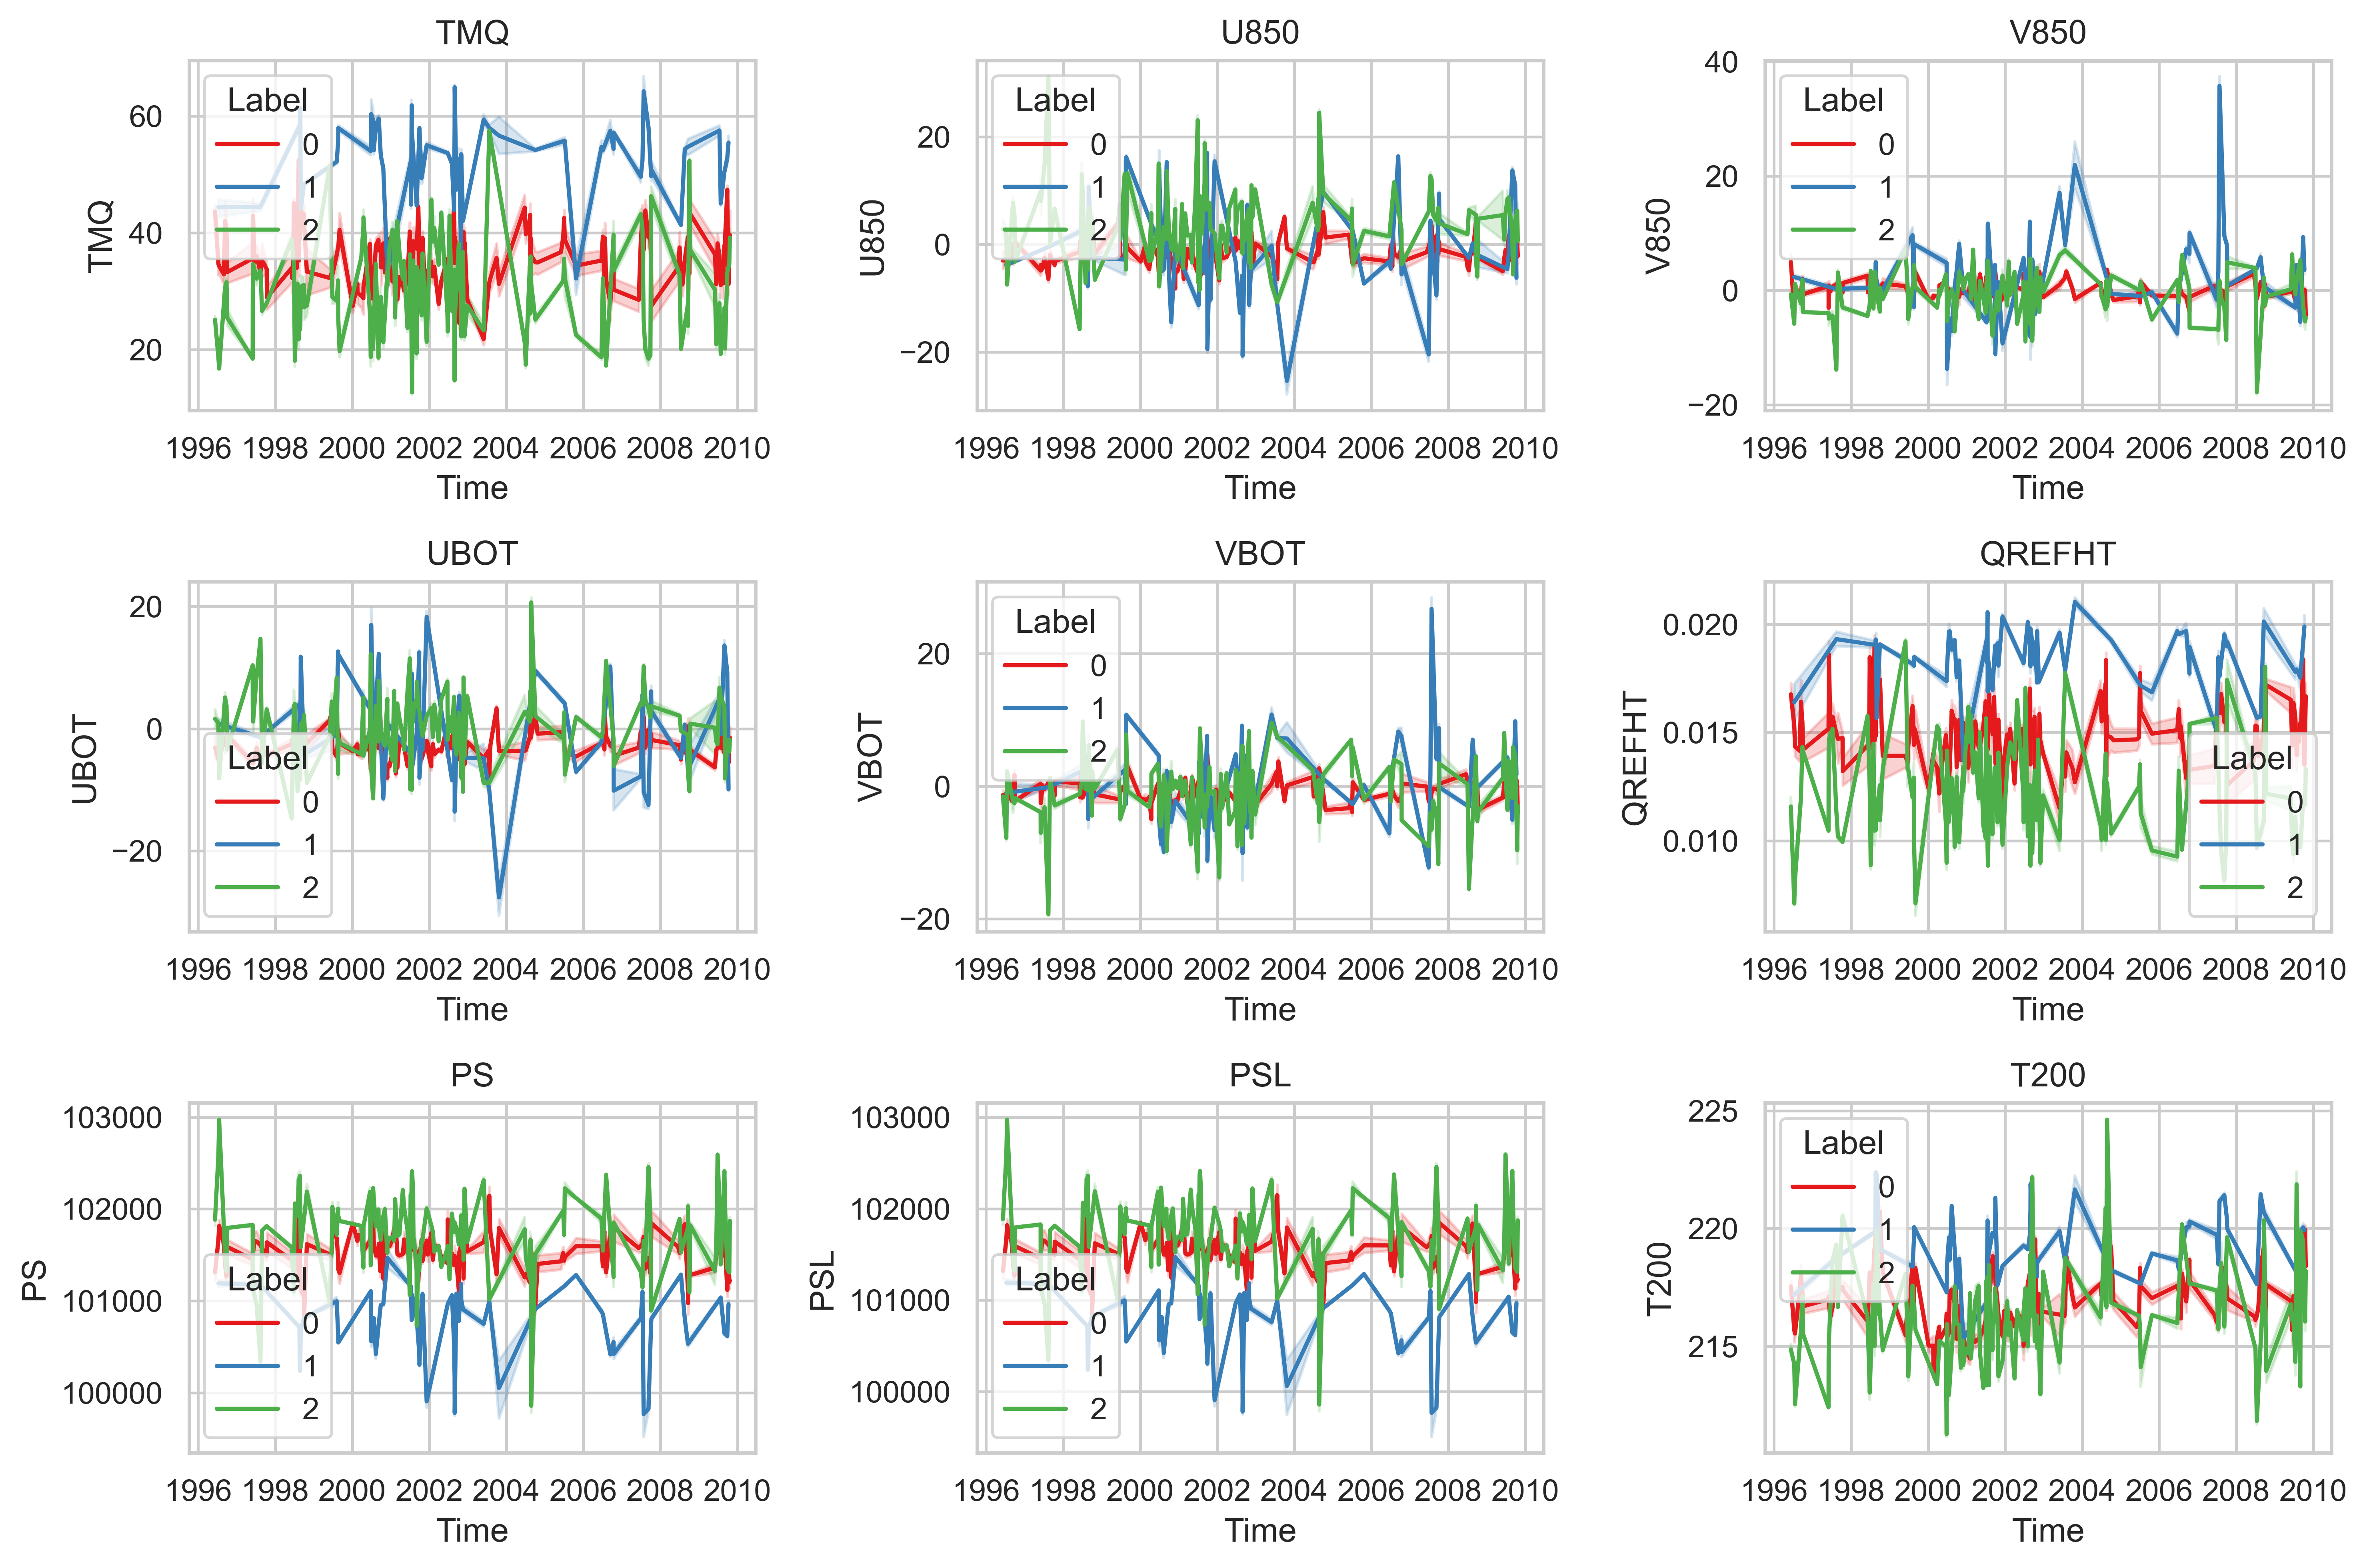

In [6]:
num_rows = 3
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8), dpi=500)

attributes_to_plot = ['TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200']

# Define a color palette for different labels
palette = sns.color_palette('Set1')

for i, attribute in enumerate(attributes_to_plot):
    row = i // num_cols
    col = i % num_cols

    # Using Seaborn for line plots and setting 'label' as the hue
    sns.lineplot(data=df, x='time', y=attribute, hue='Label', ax=axes[row, col], palette=palette)

    axes[row, col].set_title(attribute)
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel(attribute)
    axes[row, col].grid(True)

    # Add a legend to show label colors
    axes[row, col].legend(title='Label')

plt.tight_layout()  # To prevent subplot overlap
plt.show()


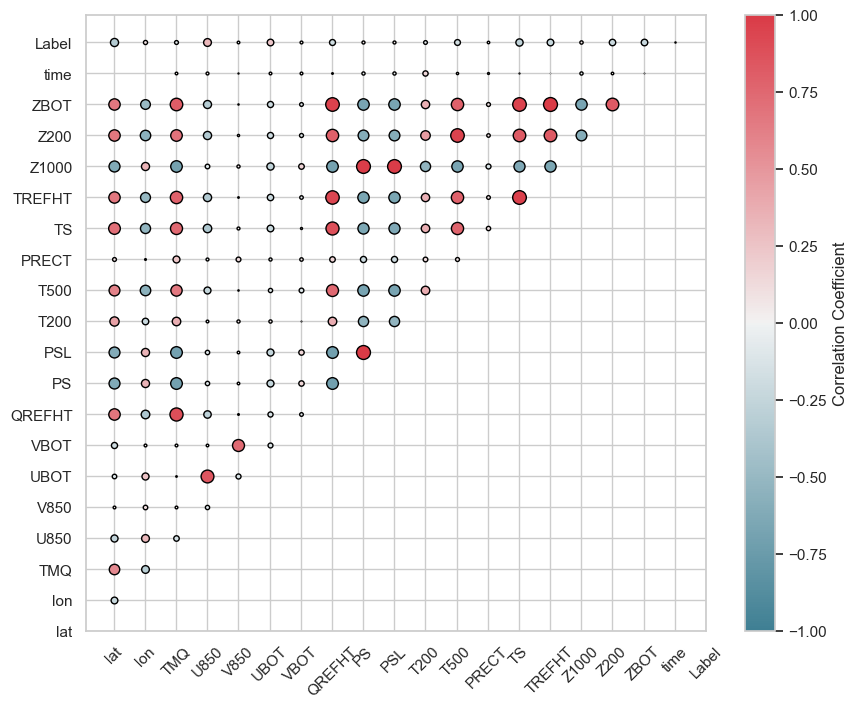

In [7]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 8))

# Define a colormap and set limits for correlation values
cmap = sns.diverging_palette(220, 10, as_cmap=True)
vmin, vmax = -1, 1

# Loop through each pair of variables in the correlation matrix
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        x = corr.columns[i]
        y = corr.columns[j]
        r = corr.iloc[i, j]

        # Calculate marker size based on the absolute correlation value
        marker_size = abs(r) * 100

        # Plot a circle with size based on correlation strength
        plt.scatter(i, j, s=marker_size, c=r, cmap=cmap, vmin=vmin, vmax=vmax, edgecolor='black')

# Customize the plot: labels, ticks, and color bar
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)

# Add a color bar to indicate the strength of correlations
cbar = plt.colorbar()
cbar.set_label('Correlation Coefficient')

# Display the plot
plt.show()


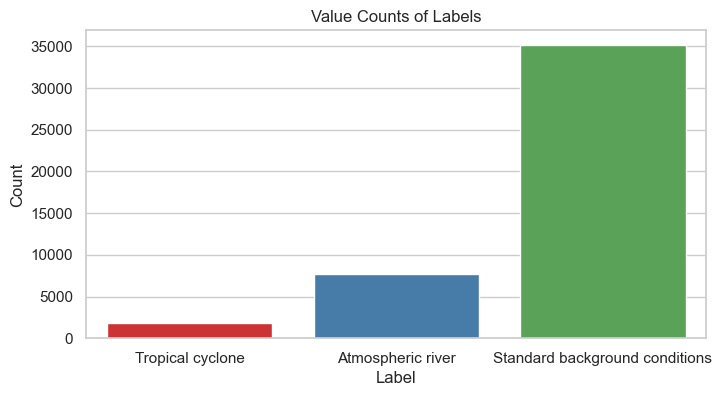

In [8]:
label_mapping = {
    0: 'Standard background conditions',
    1: 'Tropical cyclone',
    2: 'Atmospheric river'
}

# Map the label codes to custom label names
custom_labels = df['Label'].map(label_mapping)

# Create a bar plot
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x=custom_labels, palette='Set1')  # You can change the palette
plt.title('Value Counts of Labels')
plt.ylabel('Count')

plt.show()

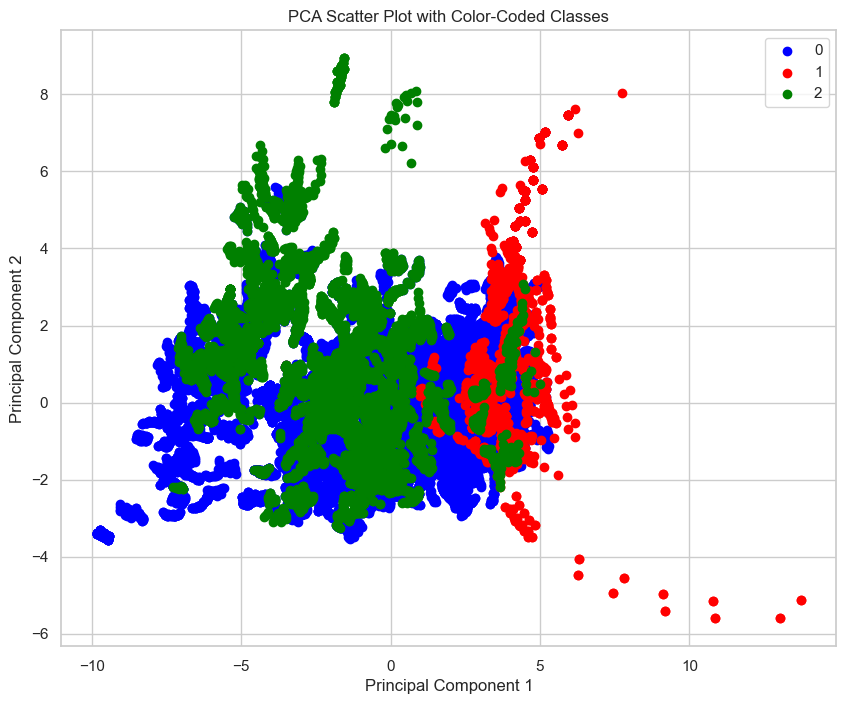

In [9]:
# Select the data for PCA
data_for_pca = df.drop(['time', 'Label'], axis=1)

# Standardize the data (important for PCA)
scaler = StandardScaler()
data_for_pca_standardized = scaler.fit_transform(data_for_pca)

# Perform PCA to reduce dimensions
n_components = 2  # You can change this to the number of components you desire
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(data_for_pca_standardized)

# Create a new DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])  # Modify column names as needed

# Add the "label" column to the PCA DataFrame
pca_df['label'] = df['Label']

# Define colors for each class
colors = {
    0: 'blue',
    1: 'red',
    2: 'green'
}

# Scatter plot the PCA results with different colors
plt.figure(figsize=(10, 8))
for label, color in colors.items():
    subset = pca_df[pca_df['label'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, c=color)

plt.title('PCA Scatter Plot with Color-Coded Classes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

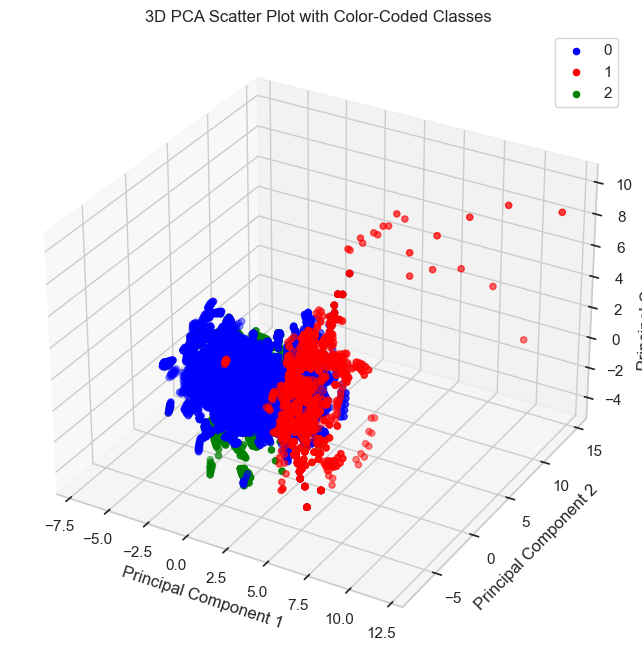

In [4]:
# Load your data into a Pandas DataFrame
# df = pd.read_csv('your_dataset.csv')

# Extract the columns you want to include in the PCA
columns_for_pca = ['TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS', 'PSL', 'T200']

# Select the data for PCA
data_for_pca = df[columns_for_pca]

data_for_pca = (data_for_pca - data_for_pca.mean())/data_for_pca.std()
# Standardize the data (important for PCA)
scaler = StandardScaler()
data_for_pca_standardized = scaler.fit_transform(data_for_pca)

# Perform PCA to reduce dimensions
n_components = 3  # We now want 3 components
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(data_for_pca_standardized)

# Create a new DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])  # Modify column names as needed

# Add the "label" column to the PCA DataFrame
pca_df['label'] = df['Label']

# Define colors for each class
colors = {
    0: 'blue',
    1: 'red',
    2: 'green'
}

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for label, color in colors.items():
    subset = pca_df[pca_df['label'] == label]
    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], label=label, c=color)

ax.set_title('3D PCA Scatter Plot with Color-Coded Classes')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()


# Baseline modelling with logreg

In [37]:
def weight_formula(n,c,y):
    return n/(c*np.bincount(y))

class_weight = weight_formula(len(y), 3, y)
# convert list to dict with indices as keys
class_weights = {i : class_weight[i] for i in range(0, len(class_weight))}

In [40]:
class_weight

array([0.42411666, 8.17534247, 1.923672  ])

In [41]:
X = df.drop(['time', 'Label'], axis=1)
y = df['Label']

X = X[['lat','PSL','Z1000','PS','Z200','TMQ','QREFHT','U850','TS']]
X = (X - X.mean())/X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [62]:
logreg = LogisticRegression(regularization="L2", lambda_reg=0.01, gamma=2.0, class_weights=class_weight)
logreg.fit(X_train, y_train)

Epoch 0, Loss: 48844.02205178481
Epoch 100, Loss: 42370.610902652115
Epoch 200, Loss: 37379.001693983286
Epoch 300, Loss: 33611.90409522134
Epoch 400, Loss: 30782.244054087856
Epoch 500, Loss: 28637.819090369194
Epoch 600, Loss: 26985.597183245733
Epoch 700, Loss: 25687.03078723022
Epoch 800, Loss: 24645.197699521985
Epoch 900, Loss: 23792.58746810227


In [63]:
# compute accuracy of test predictions
y_pred = logreg.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f'Accuracy: {accuracy:.2%}')

Accuracy: 43.90%


In [64]:
y_pred

array([2, 2, 2, ..., 1, 1, 1])

In [66]:
np.unique(y_pred)

array([0, 1, 2])

In [60]:
# Create a logistic regression model with class weights
model = LogisticRegression(random_seed=RANDOM_SEED)

# Create Stratified K-Fold cross-validator
num_splits = 10
stratified_kfold = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=RANDOM_SEED)

# Lists to store evaluation metrics
accuracy_scores = []

X = (X-X.mean())/X.std()
# Perform cross-validation
for train_index, test_index in stratified_kfold.split(X, y):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate and store the accuracy score for this fold
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)

# Calculate the mean accuracy score across all folds
mean_accuracy = np.mean(accuracy_scores)
print("Mean Accuracy:", mean_accuracy)


Mean Accuracy: 0.7859472743521001


In [26]:
np.unique(y_pred)

array([0, 1, 2])

# Feature engineering

In [12]:
# Create a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=0, class_weight='balanced')

# Fit the model to your data
rf_model.fit(X, y)

# Get feature importances
feature_importances = rf_model.feature_importances_

# Sort and print the feature importances
feature_importance_ranking = sorted(zip(feature_importances, df.columns), reverse=True)
for importance, feature_name in feature_importance_ranking:
    print(f"{feature_name}: {importance:.4f}")

lon: 0.1723
lat: 0.1390
U850: 0.1111
TMQ: 0.1098
V850: 0.1050
QREFHT: 0.0970
VBOT: 0.0936
PS: 0.0897
UBOT: 0.0825


In [29]:
feature_importances

array([0.1075985 , 0.01794868, 0.06646753, 0.05768242, 0.03003473,
       0.03897928, 0.03404949, 0.062668  , 0.0802456 , 0.10463418,
       0.04037742, 0.04658208, 0.01164873, 0.05215175, 0.03200799,
       0.10294273, 0.0755527 , 0.03842821])

In [30]:
import shap
# Create a SHAP explainer for your model
explainer = shap.TreeExplainer(rf_model)

# Calculate SHAP values for all features
shap_values = explainer(X)

# Summarize the feature importances
shap.summary_plot(shap_values, X, plot_type="bar")

# Submission

In [67]:
test = pd.read_csv('data/test.csv',parse_dates=['time'])
test.head()

,SNo,lat,lon,TMQ,U850,V850,UBOT,VBOT,QREFHT,PS,PSL,T200,T500,PRECT,TS,TREFHT,Z1000,Z200,ZBOT,time
0,1,-30.391134,354.375,25.907482,6.662070,-17.510447,-7.432653,-3.936030,0.010624,101532.5391,101532.5391,213.092209,256.032043,3.350000e-09,290.697632,290.039947,129.814316,11948.68848,63.752274,2010-10-09
1,2,-30.391134,354.375,25.907482,6.662070,-17.510447,-7.432653,-3.936030,0.010624,101532.5391,101532.5391,213.092209,256.032043,3.350000e-09,290.697632,290.039947,129.814316,11948.68848,63.752274,2010-10-09
2,3,-31.095176,354.375,27.019733,4.951319,-17.341263,-7.286631,-3.150316,0.010890,101513.0234,101513.0234,213.161011,255.616837,1.890000e-11,290.372650,289.940613,128.204788,11931.06738,63.753948,2010-10-09
3,4,-31.095176,354.375,27.019733,4.951319,-17.341263,-7.286631,-3.150316,0.010890,101513.0234,101513.0234,213.161011,255.616837,1.890000e-11,290.372650,289.940613,128.204788,11931.06738,63.753948,2010-10-09
4,5,-30.860495,354.375,26.516499,5.362008,-17.227922,-7.257047,-2.907396,0.010821,101505.1484,101505.1484,213.188248,255.498810,1.130000e-09,290.697632,290.041351,127.552147,11936.12500,63.761059,2010-10-09


In [68]:
X_sub = test[['lat','PSL','Z1000','PS','Z200','TMQ','QREFHT','U850','TS']]
X_sub = (X_sub - X_sub.mean())/X_sub.std()

In [70]:
y_sub = logreg.predict(X_sub.values)

In [71]:
sub = pd.DataFrame({'SNo':test['SNo'],'Label':y_sub})
sub.to_csv('data/submission.csv',index=False)

# Submission

In [ ]:
df_test = pd.read_csv('test.csv',parse_dates=['time']).set_index('time').sort_index()
df_test.head()

In [ ]:
# Create a map centered around the mean of the latitude and longitude data
m = folium.Map(location=[df_test['lat'].mean(), df_test['lon'].mean()], zoom_start=4)

# Creating the heatmap
heat_data = [[row['lat'], row['lon'], row['PS']] for index, row in df_test.iterrows()]
HeatMap(heat_data).add_to(m)

m.save('map_test.html')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(df[['lat','lon']], dbscan.labels_)

new_data = df_test[['lat','lon']]
df_test['Region'] = knn.predict(new_data)